# Relevant Library Import

In [ ]:
!pip install ace_tools
!pip install --upgrade scikit-learn scikeras tensorflow optuna category_encoders xgboost ace_tools

In [ ]:


# Basic libraries
import os
import warnings  # Suppress warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import urllib.request

# Machine learning and data cleaning
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
# statitics
from scipy.stats import boxcox, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor
# machine learning model
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay
)

# deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

# hyperparameter tuning
import optuna
import time






# Get the Data


## Download the Data
Data is pre-downloaded into drop box
Original URL: https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

In [ ]:

# Suppress FutureWarnings from seaborn
warnings.simplefilter(action='ignore', category=FutureWarning)
def load_student_data():
    csv_path = Path("datasets/student_data.csv")

    # Check if the file exists locally; if not, download it from Dropbox
    if not csv_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)

        # Dropbox direct download link (replace dl=0 with dl=1)
        url = "https://www.dropbox.com/scl/fi/icpzk8b3abezvusaky5t8/dropout_academic_success_predictdata.csv?rlkey=57v3934kvs98rixwvrges9l7q&st=iwpgr94s&dl=1"

        # Download and save the file locally
        urllib.request.urlretrieve(url, csv_path)

    # Read the CSV file into a Pandas DataFrame
    return pd.read_csv(csv_path, sep = ';')

# Load the dataset
student_data = load_student_data()

# Display the first few rows
student_data.head()


,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Modify column Name


In [ ]:
# clean df column names
def clean_column_names(df):
    df.columns = (
        df.columns.str.strip()
                 .str.lower()
                 .str.replace(" ", "_")
                 .str.replace(r"[()'/]", "", regex=True)
    )
    return df


student_data = clean_column_names(student_data)

print("✅ columns after alternation:", student_data.columns.tolist())

✅ columns after alternation: ['marital_status', 'application_mode', 'application_order', 'course', 'daytimeevening_attendance', 'previous_qualification', 'previous_qualification_grade', 'nacionality', 'mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation', 'admission_grade', 'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'age_at_enrollment', 'international', 'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_evaluations', 'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations', 'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade', 'curricular_units_2nd_sem_without_evaluations', 'unemployment_rate', 'inflation_rate', 'gdp', 'target']


## Data Statistics

In [ ]:
# Basic exploration of the dataset
def explore_student_data(df,num_cols):

    # set pandas illustration options
    pd.set_option("display.max_columns", None)  # display all columns
    pd.set_option("display.width", 1000)  # avoid new line
    pd.set_option("display.max_colwidth", None)  # allow long string

    # illustrate basic df info
    print("Basic Information:")
    print(df.info())  # Column types & missing values
    print("\n📊 First 3 Rows:")
    print(df.head(3))  # Display first few rows

    # 📊 Display summary statistics for numerical variables
    print("\n📈 Numerical Column Statistics:")
    print(student_data[num_cols].describe())
    # Identify categorical columns (all remaining ones)
    cat_cols = [col for col in student_data.columns if col not in num_cols]
    # Print unique value counts for categorical variables
    print("\n📋 Unique Values in Categorical Columns:")
    for col in cat_cols:
        unique_vals = student_data[col].nunique()
        print(f"{col}: {unique_vals} unique values")

    print("\n🔍 Checking for Missing Values:")
    print(df.isnull().sum())  # Count missing values in each column
    print("\n⚖ Class Distribution:")
    if "target" in df.columns:  # Replace 'target' with actual column name
        print(df["target"].value_counts(normalize=True))  # Target class distribution
    else:
        print("Target variable not found. Ensure correct column name.")



    # set pandas options to default
    pd.reset_option("display.max_columns")
    pd.reset_option("display.width")
    pd.reset_option("display.max_colwidth")
# Run the function

    # Define known numerical columns
num_cols = ["admission_grade", "unemployment_rate", "inflation_rate", "gdp","age_at_enrollment", 'previous_qualification_grade'] + \
        [col for col in student_data.columns if "curricular_units" in col]

# Define categorical variables
cat_cols = [col for col in student_data.columns if col not in num_cols]

explore_student_data(student_data, num_cols)


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   marital_status                                4424 non-null   int64  
 1   application_mode                              4424 non-null   int64  
 2   application_order                             4424 non-null   int64  
 3   course                                        4424 non-null   int64  
 4   daytimeevening_attendance                     4424 non-null   int64  
 5   previous_qualification                        4424 non-null   int64  
 6   previous_qualification_grade                  4424 non-null   float64
 7   nacionality                                   4424 non-null   int64  
 8   mothers_qualification                         4424 non-null   int64  
 9   fathers_qualification                       

# Exploratory Data Analysis(EDA)

## Target Variable Distribution

column = 'target'

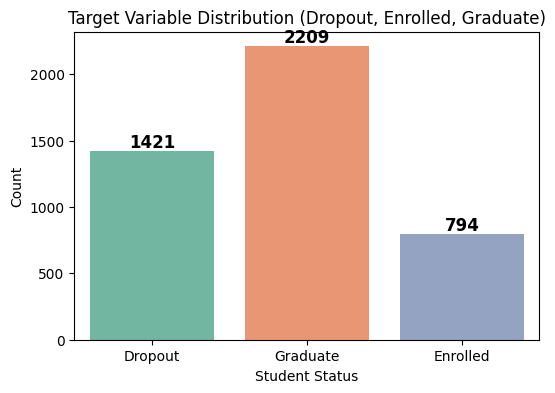

In [ ]:

# Set figure size
plt.figure(figsize=(6,4))

# Create the countplot
ax = sns.countplot(x="target", data=student_data, palette="Set2")

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # Display the count as an integer
                (p.get_x() + p.get_width() / 2, p.get_height()),  # Position label at the center-top of each bar
                ha='center', va='bottom',  # Center horizontally, position above the bar
                fontsize=12, fontweight='bold', color='black')  # Style the text

# Add title and axis labels
plt.title("Target Variable Distribution (Dropout, Enrolled, Graduate)")
plt.xlabel("Student Status")
plt.ylabel("Count")

# Display the plot
plt.show()

## EDA for Numerical Column
Included column:


In [ ]:
print(num_cols)

['admission_grade', 'unemployment_rate', 'inflation_rate', 'gdp', 'age_at_enrollment', 'previous_qualification_grade', 'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_evaluations', 'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations', 'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade', 'curricular_units_2nd_sem_without_evaluations']


### Box Plot

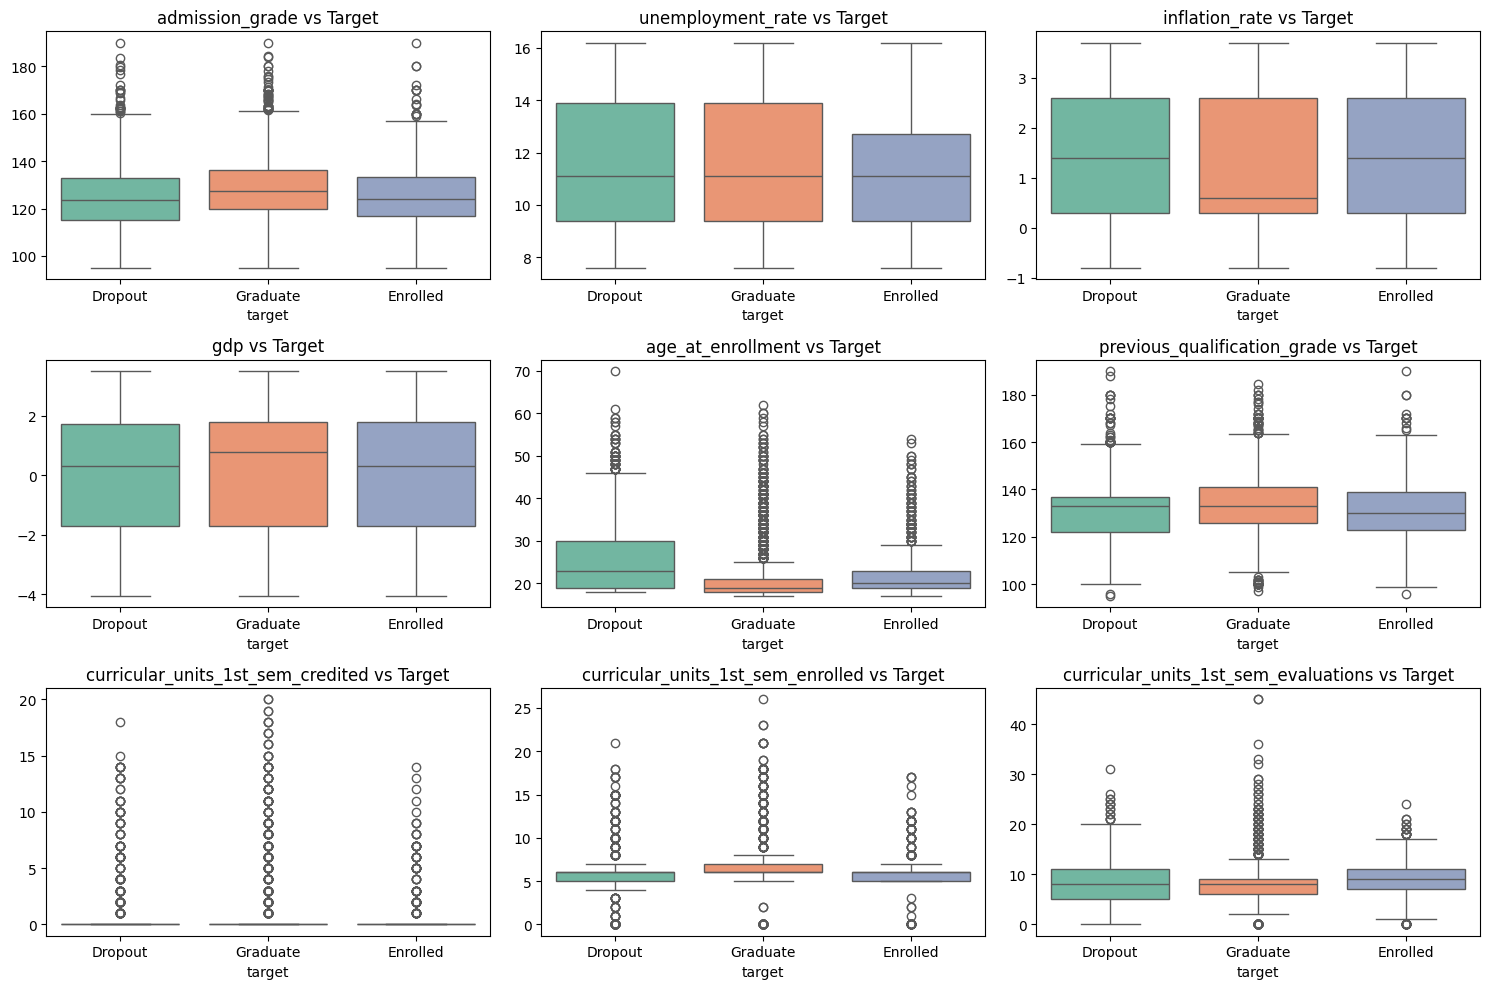

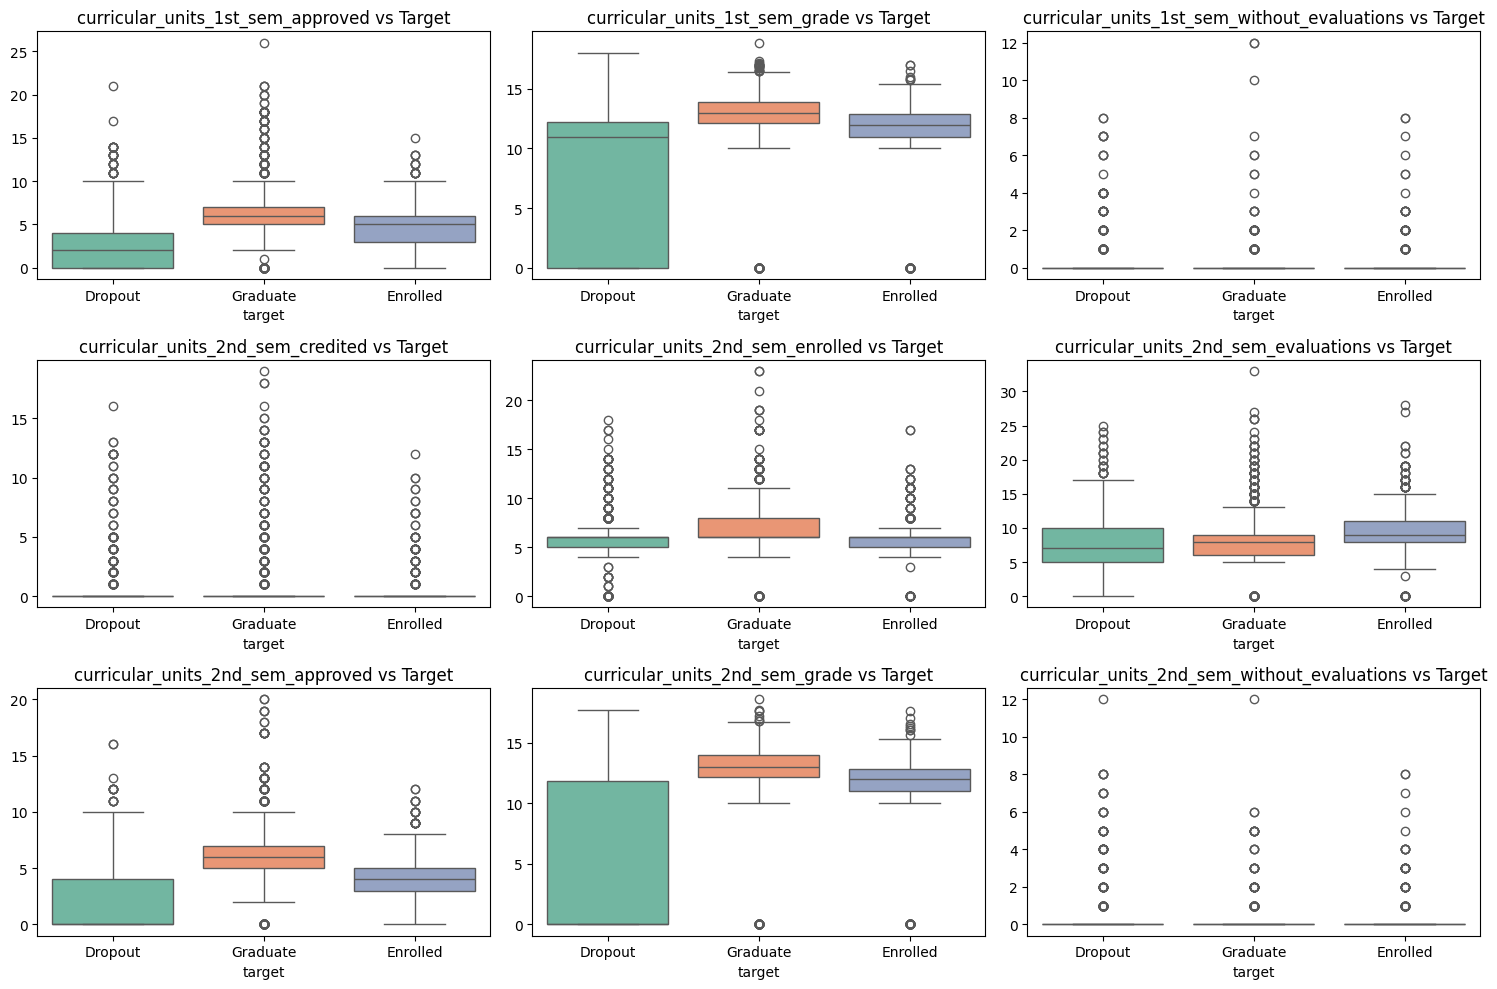

In [ ]:

# Define the number of columns per figure
cols_per_fig = 9  # Number of subplots per figure
total_cols = len(num_cols)
num_figs = (total_cols // cols_per_fig) + (total_cols % cols_per_fig > 0)  # Calculate number of figures

# Loop through the features and create multiple plots
for fig_idx in range(num_figs):
    plt.figure(figsize=(15, 10))  # Create a new figure

    start_idx = fig_idx * cols_per_fig  # Starting column index for this figure
    end_idx = min(start_idx + cols_per_fig, total_cols)  # Ending column index

    # Create subplots for the current figure
    for i, col in enumerate(num_cols[start_idx:end_idx], 1):
        plt.subplot(3, 3, i)  # Arrange in a 3x3 grid
        ax = sns.boxplot(x="target", y=student_data[col], data=student_data, hue="target", legend=False, palette="Set2")
        plt.title(f"{col} vs Target")
        ax.set_ylabel('')  # Remove y-axis label

    plt.tight_layout()
    plt.show()  # Show the current figure before moving to the next one


### Hystogram

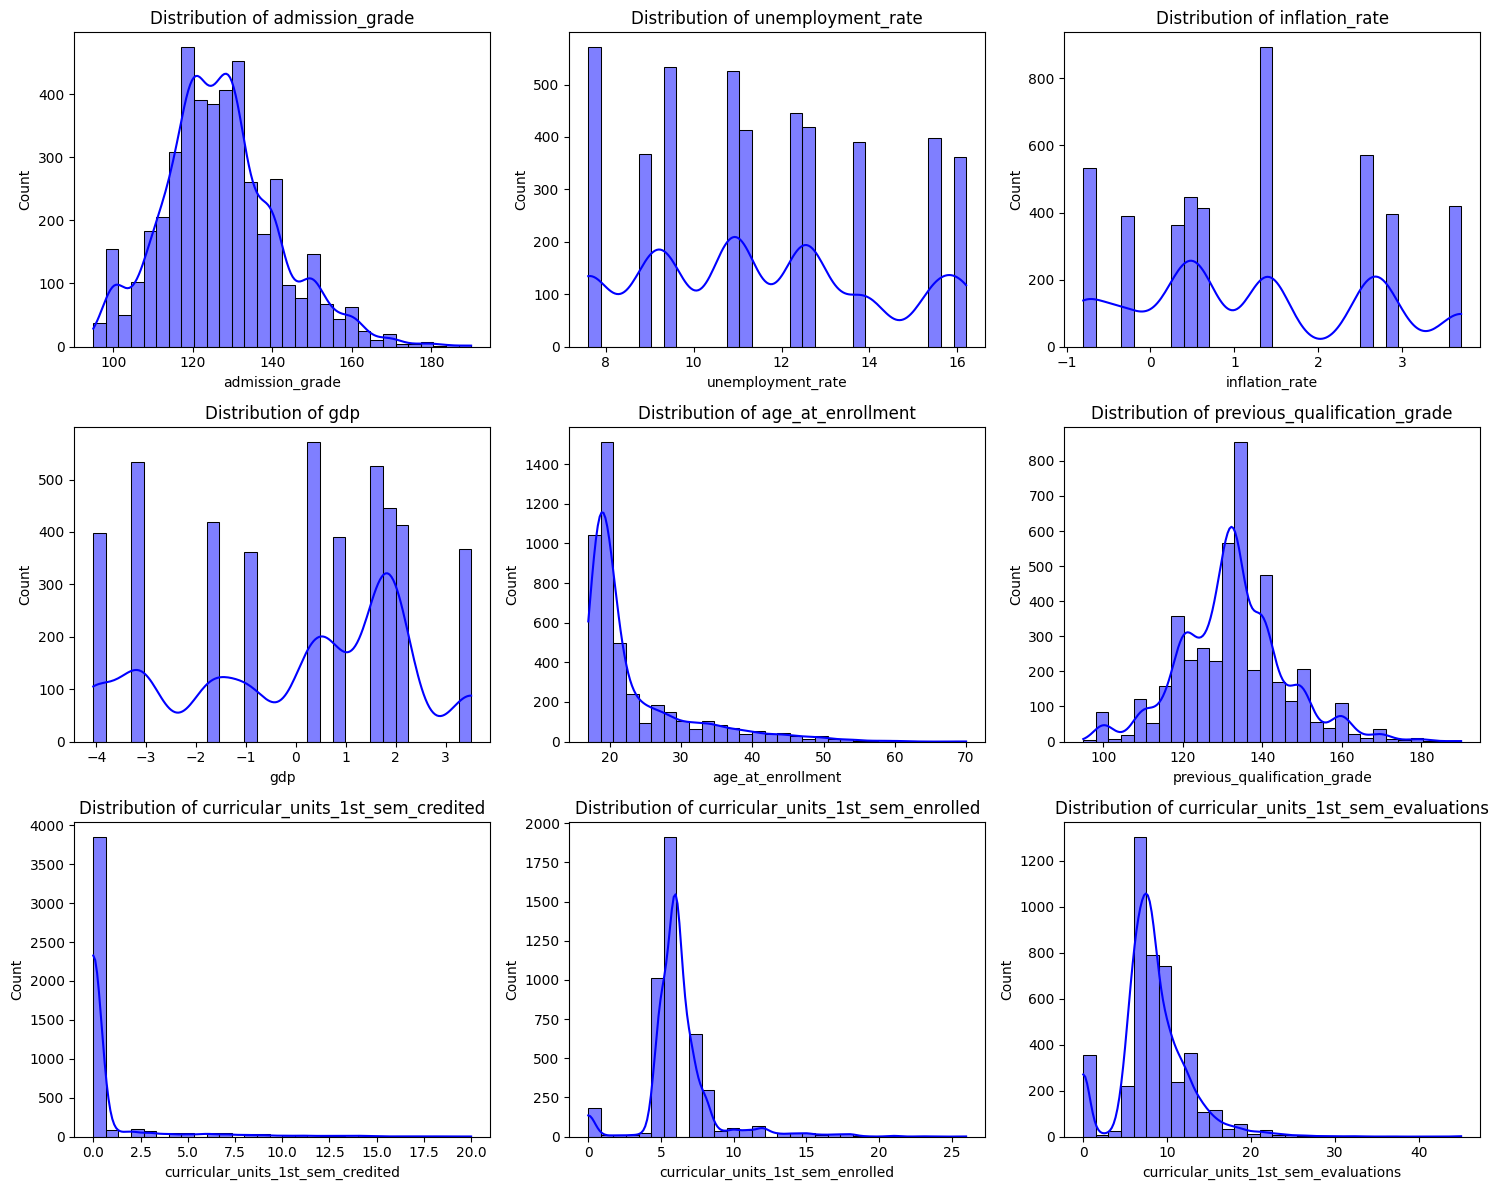

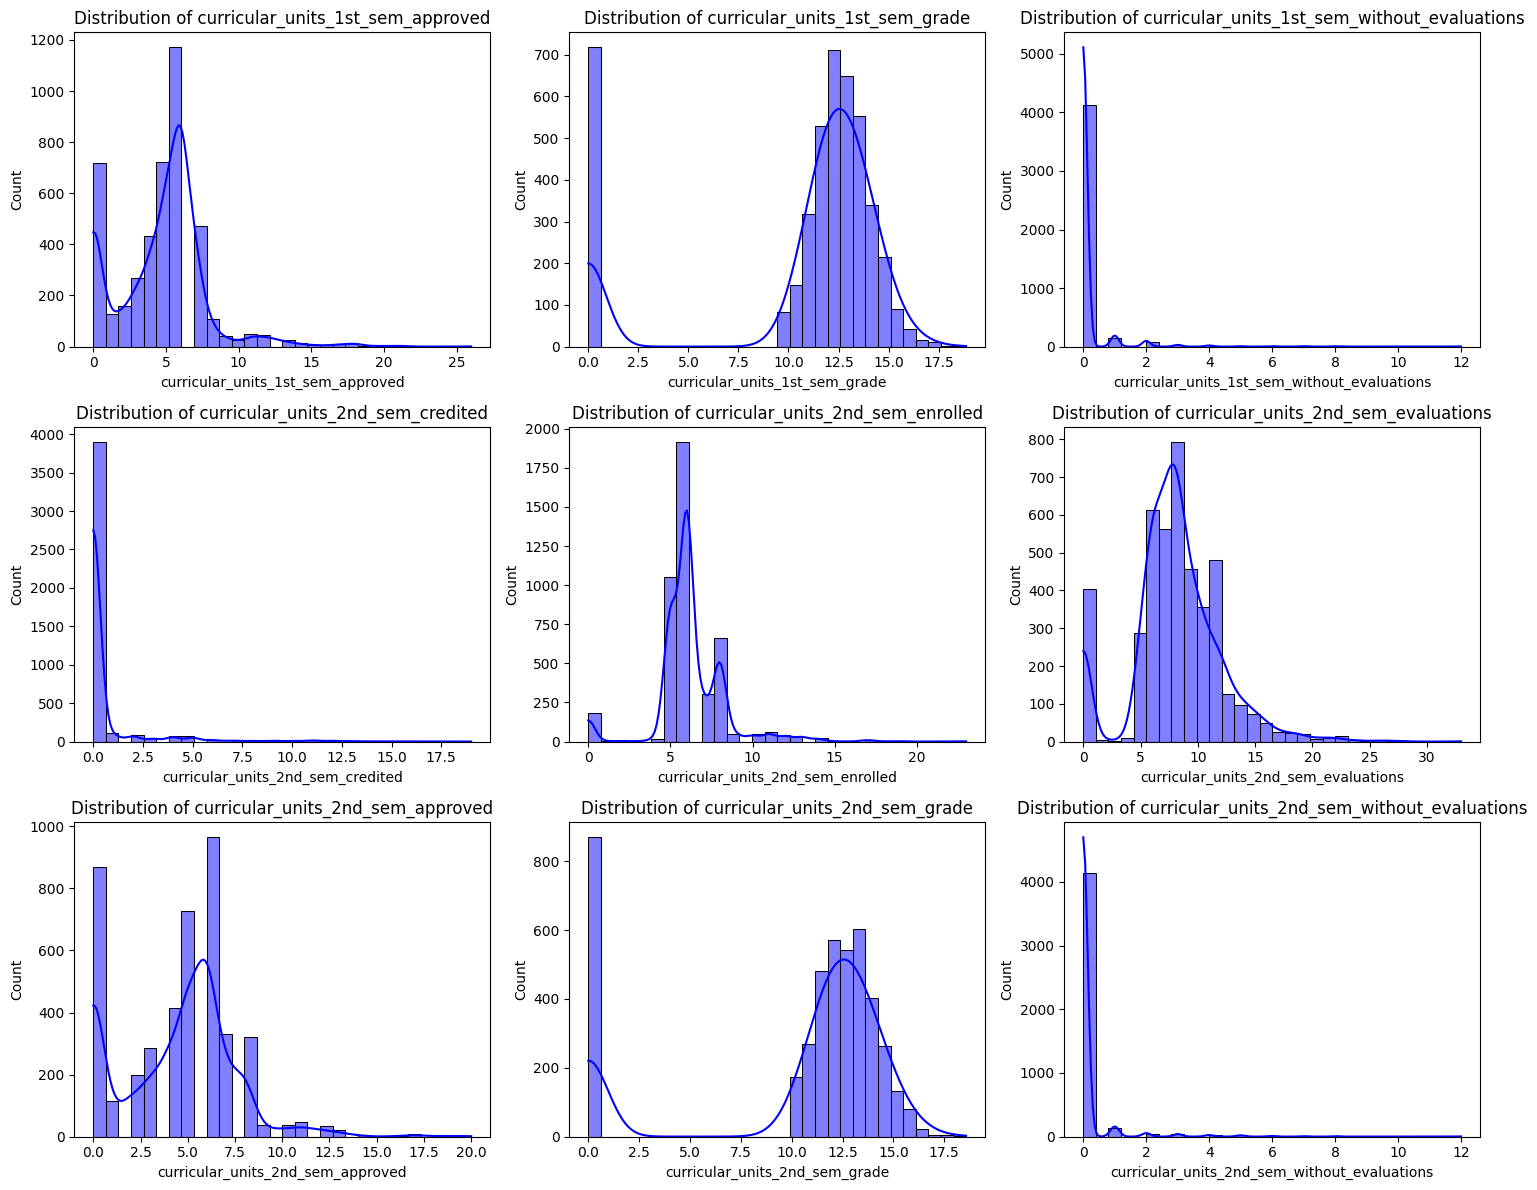

In [ ]:

# Define the number of columns per figure
cols_per_fig = 9  # Maximum 9 plots per figure
total_cols = len(num_cols)
num_figs = (total_cols // cols_per_fig) + (total_cols % cols_per_fig > 0)  # Number of figures needed

# Loop to create multiple figures
for fig_idx in range(num_figs):
    plt.figure(figsize=(15, 12))  # Create new figure

    start_idx = fig_idx * cols_per_fig  # Start index for this figure
    end_idx = min(start_idx + cols_per_fig, total_cols)  # End index

    # Create subplots for this batch
    for i, col in enumerate(num_cols[start_idx:end_idx], 1):
        plt.subplot(3, 3, i)
        sns.histplot(student_data[col], bins=30, kde=True, color="blue", edgecolor="black")
        plt.title(f"Distribution of {col}")

    plt.tight_layout()
    plt.show()  # Show current figure before moving to the next one



### Heat Map for Numerical Columns

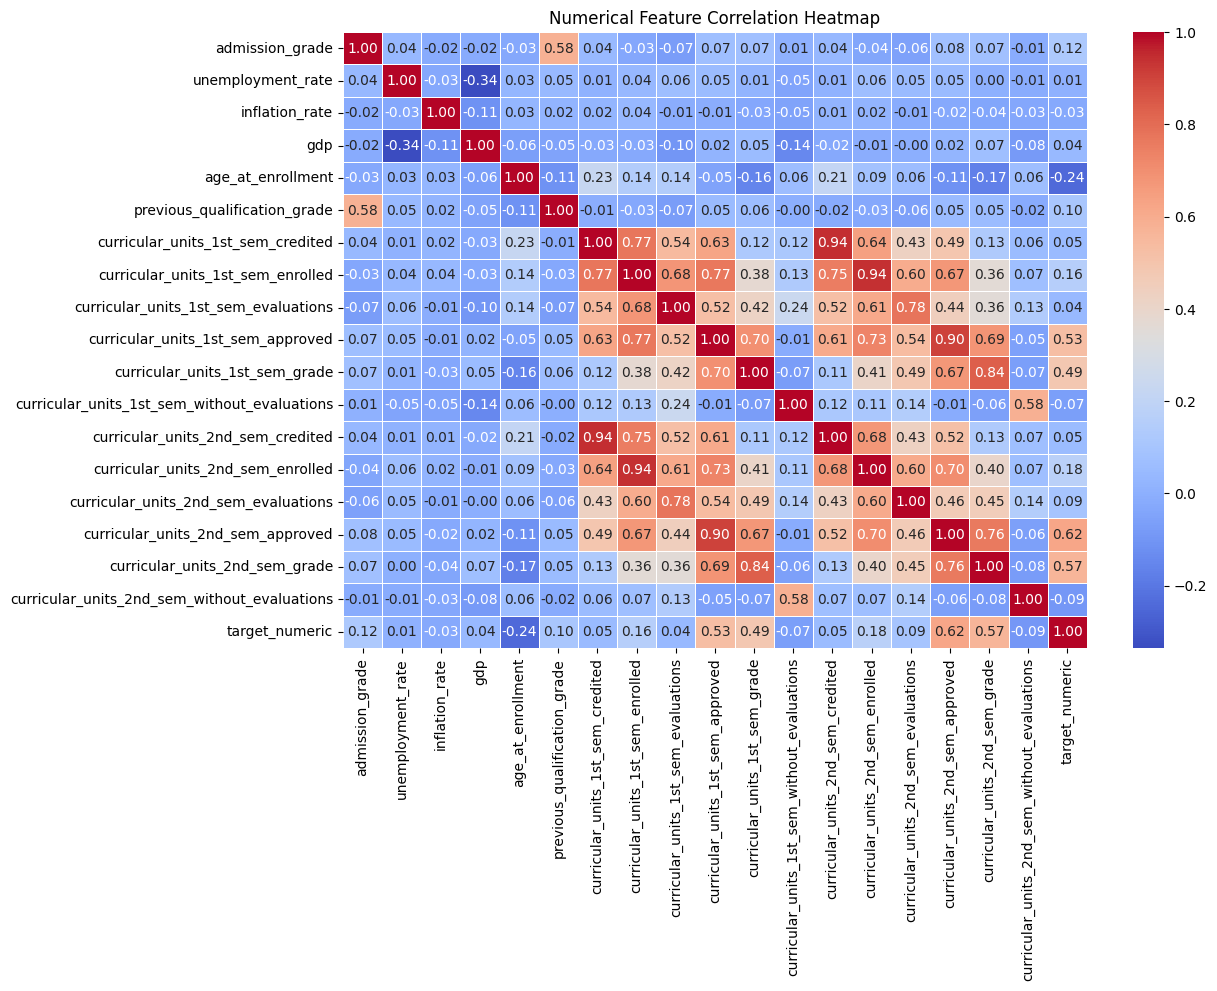

,Feature,VIF
0,admission_grade,111.558765
1,unemployment_rate,21.224705
2,inflation_rate,1.842639
3,gdp,1.181265
4,age_at_enrollment,11.214115
5,previous_qualification_grade,120.817662
6,curricular_units_1st_sem_credited,16.858292
7,curricular_units_1st_sem_enrolled,172.414269
8,curricular_units_1st_sem_evaluations,19.589936
9,curricular_units_1st_sem_approved,41.723623


In [ ]:

# Encode categorical target variable for correlation
student_data["target_numeric"] = student_data["target"].astype("category").cat.codes

# Compute correlation
correlation_matrix = student_data[num_cols + ["target_numeric"]].corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Numerical Feature Correlation Heatmap")
plt.show()
# Create DataFrame with only numerical features
X = student_data[num_cols].dropna()  # Drop missing values to avoid VIF calculation errors

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Display VIF report
from IPython.display import display
display(vif_data)

### A Closer Look of Distribution

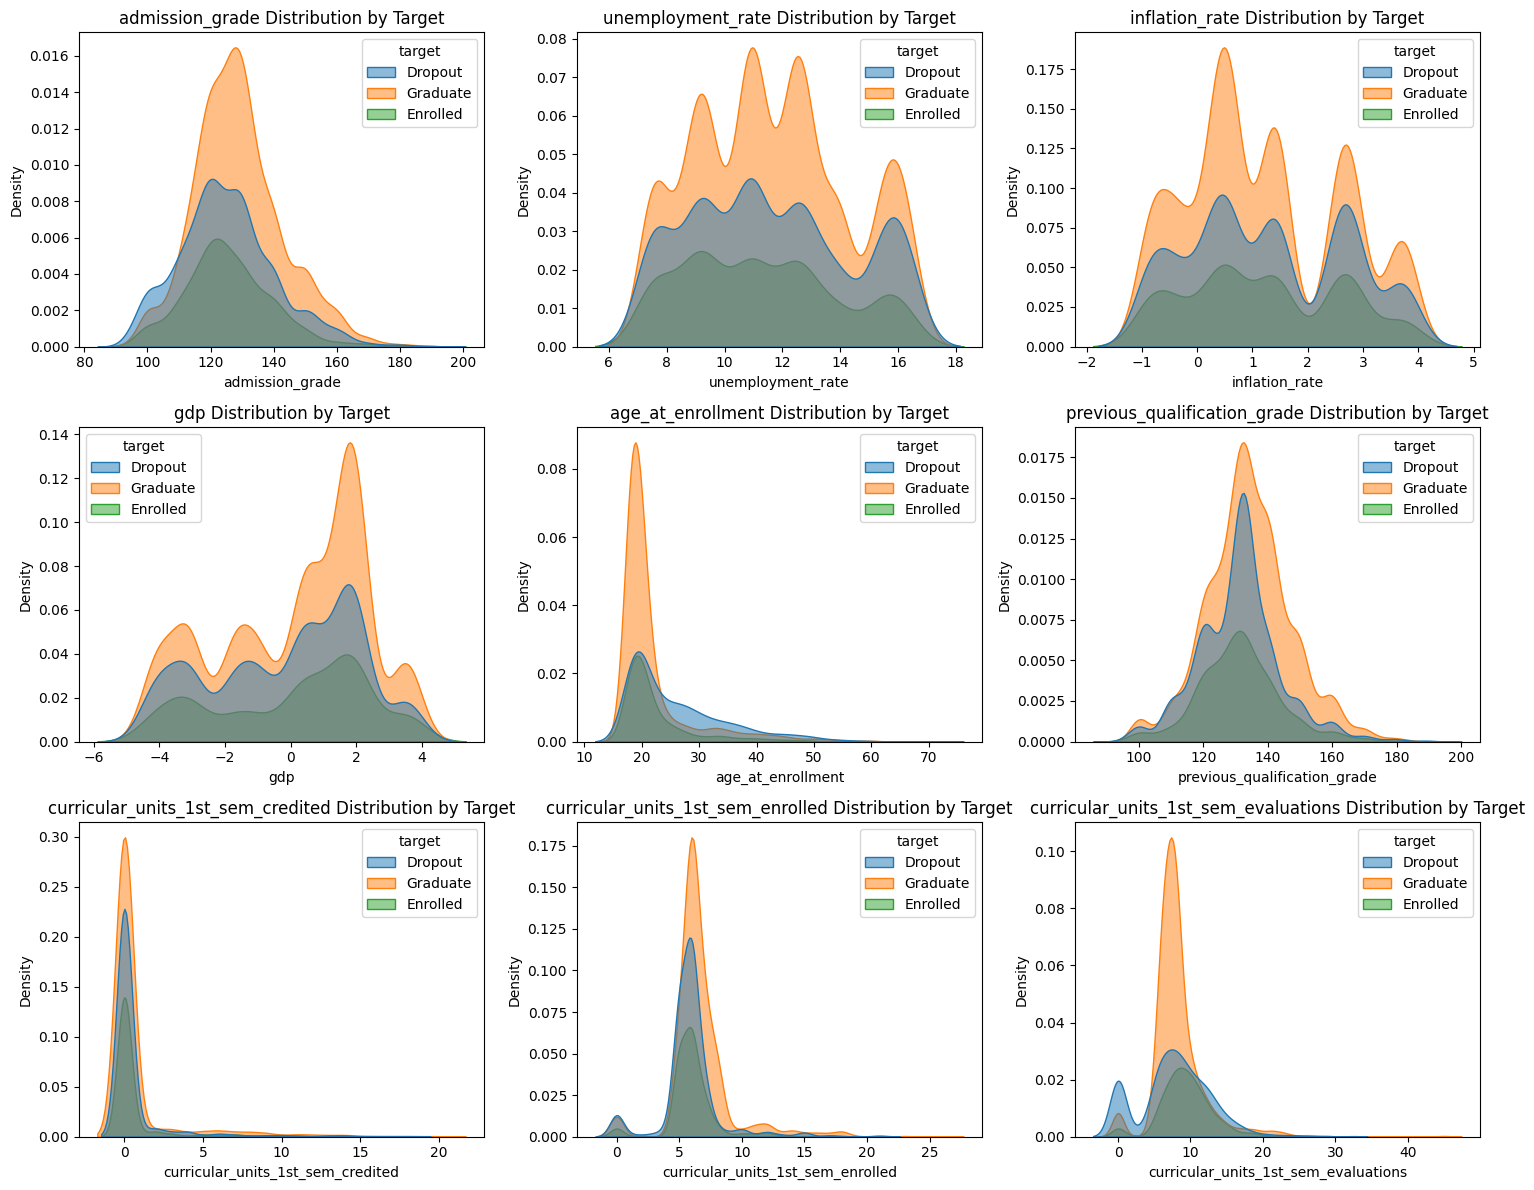

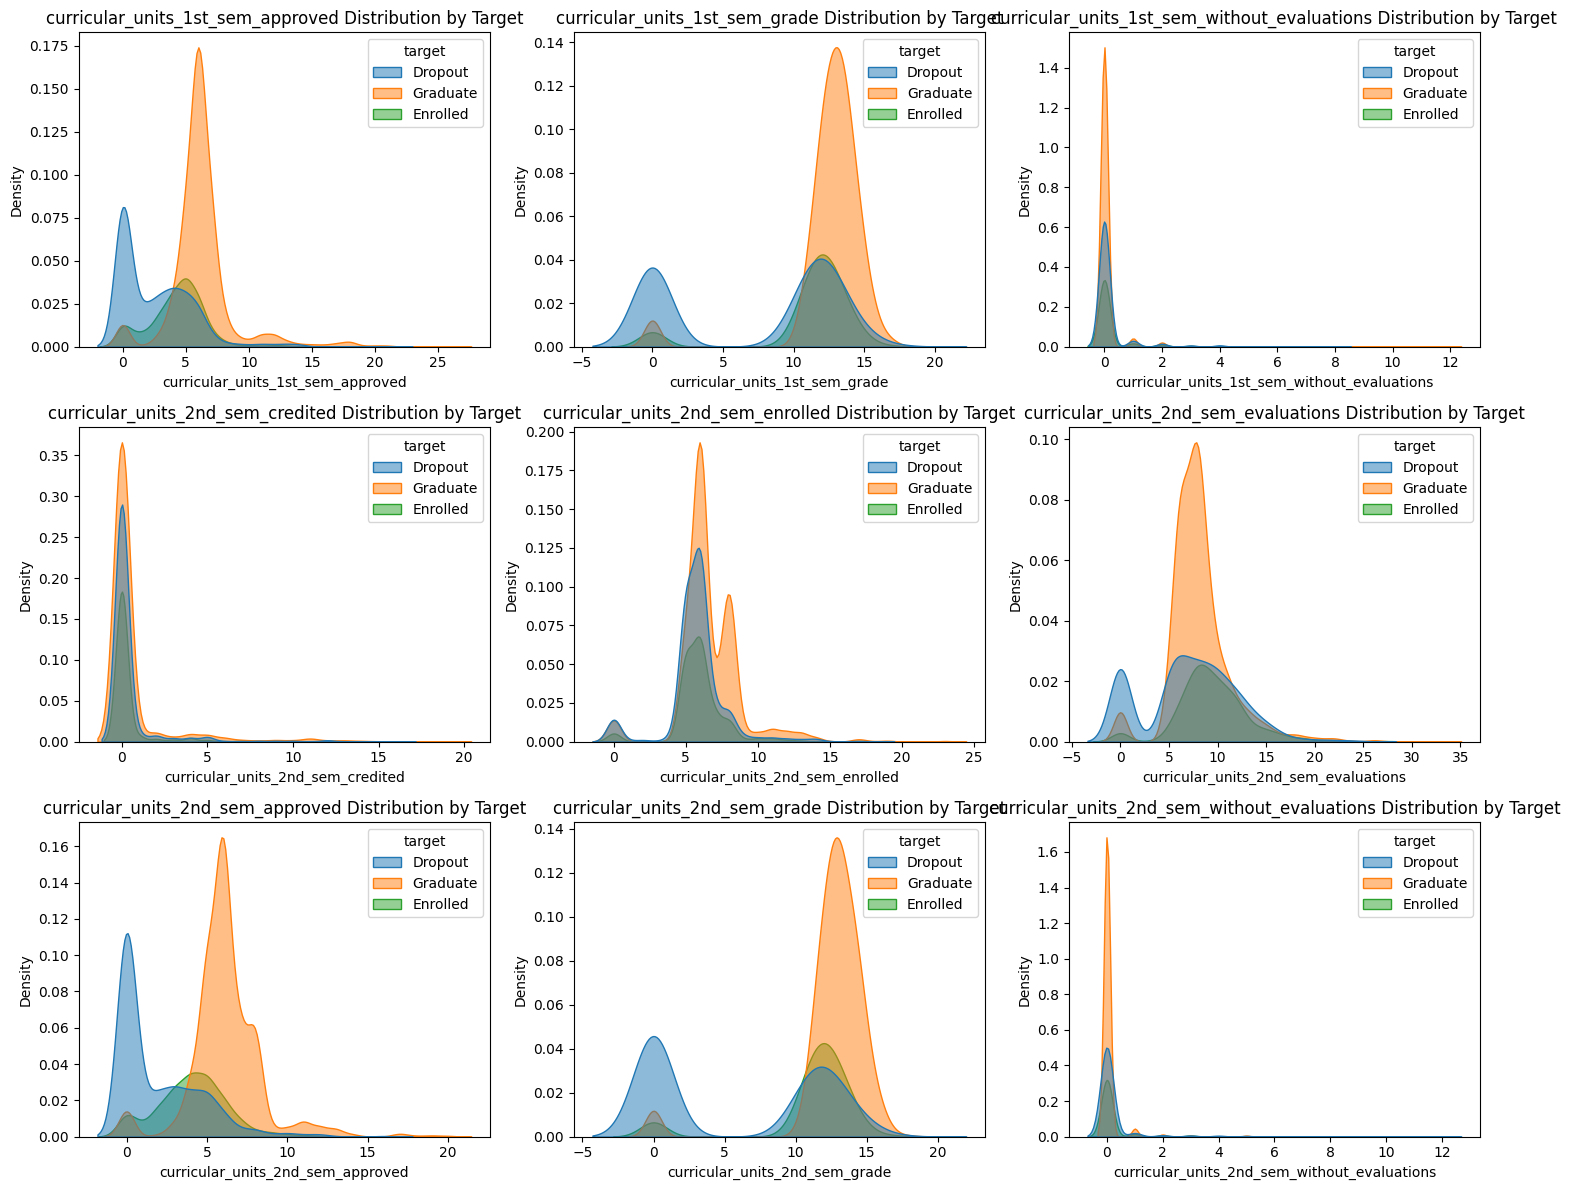

In [ ]:

# Define the number of columns per figure
cols_per_fig = 9  # Maximum 9 plots per figure
total_cols = len(num_cols)
num_figs = (total_cols // cols_per_fig) + (total_cols % cols_per_fig > 0)  # Number of figures needed

# Loop through the features and create multiple figures
for fig_idx in range(num_figs):
    plt.figure(figsize=(15, 12))  # Create a new figure

    start_idx = fig_idx * cols_per_fig  # Starting index for this figure
    end_idx = min(start_idx + cols_per_fig, total_cols)  # Ending index

    # Create subplots for the current figure
    for i, col in enumerate(num_cols[start_idx:end_idx], 1):
        plt.subplot(3, 3, i)  # Arrange in a 3x3 grid
        sns.kdeplot(data=student_data, x=col, hue="target", fill=True, alpha=0.5)
        plt.title(f"{col} Distribution by Target")

    plt.tight_layout()
    plt.show()  # Show the current figure before moving to the next one



## EDA Categorical

### Histogram

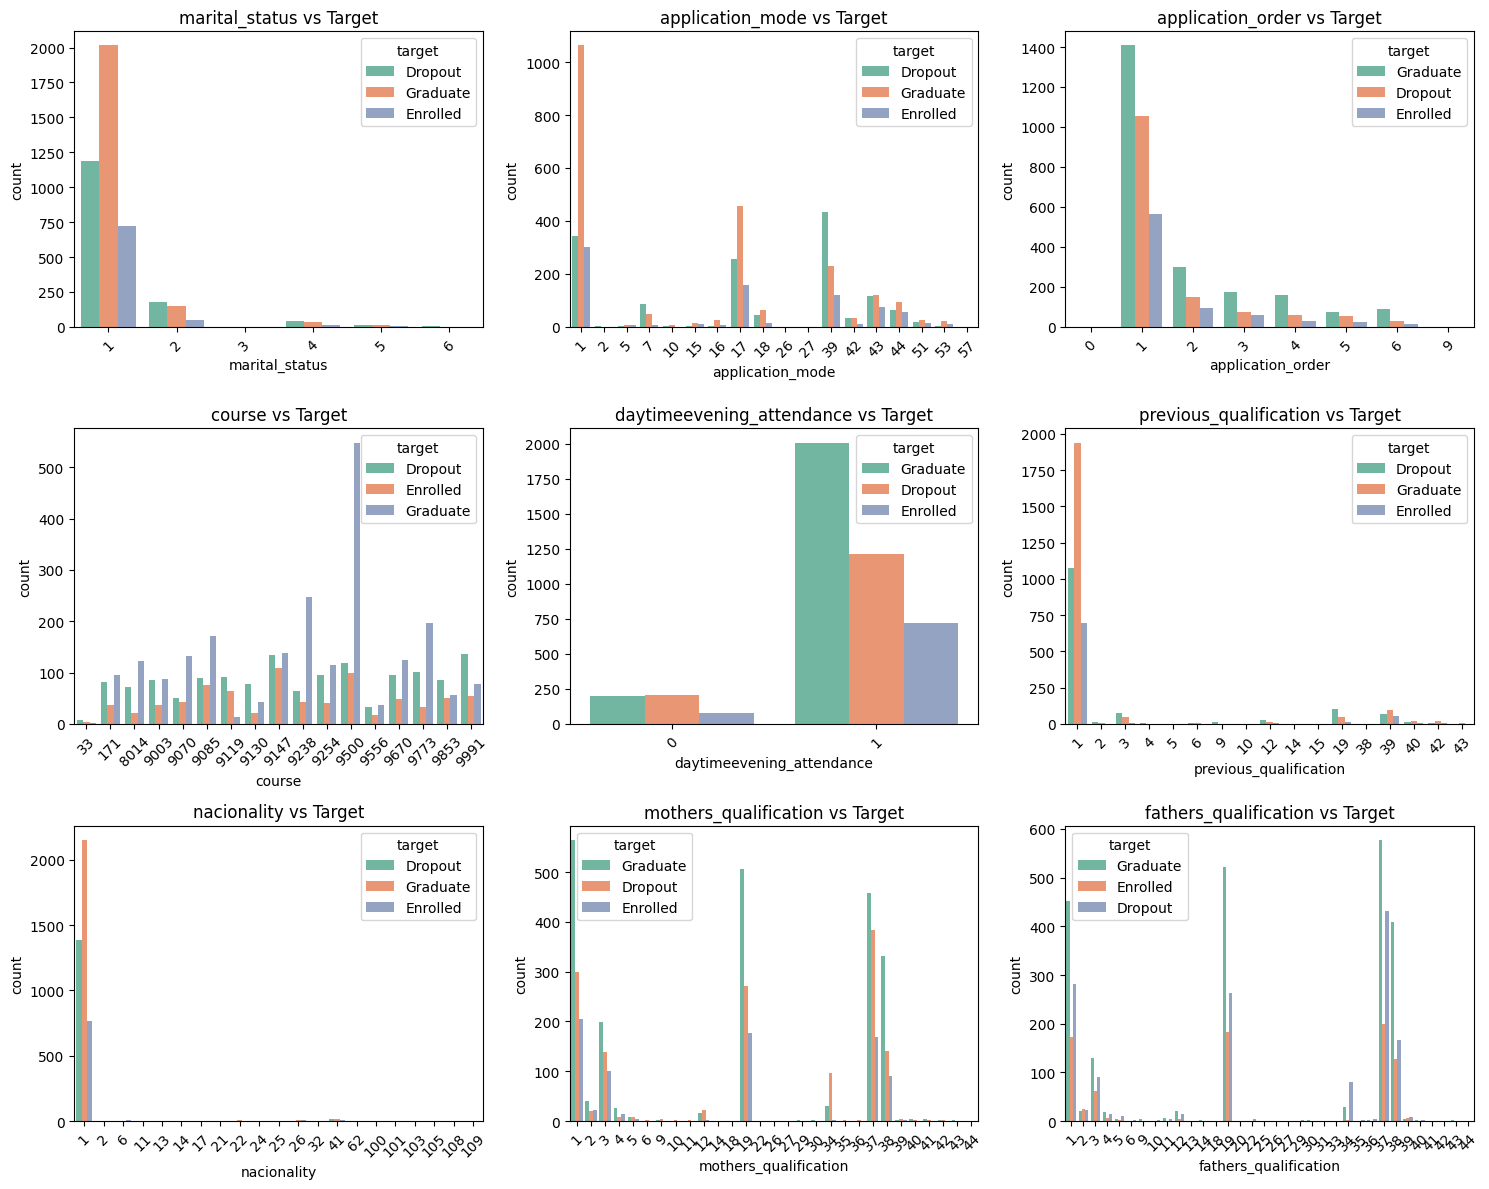

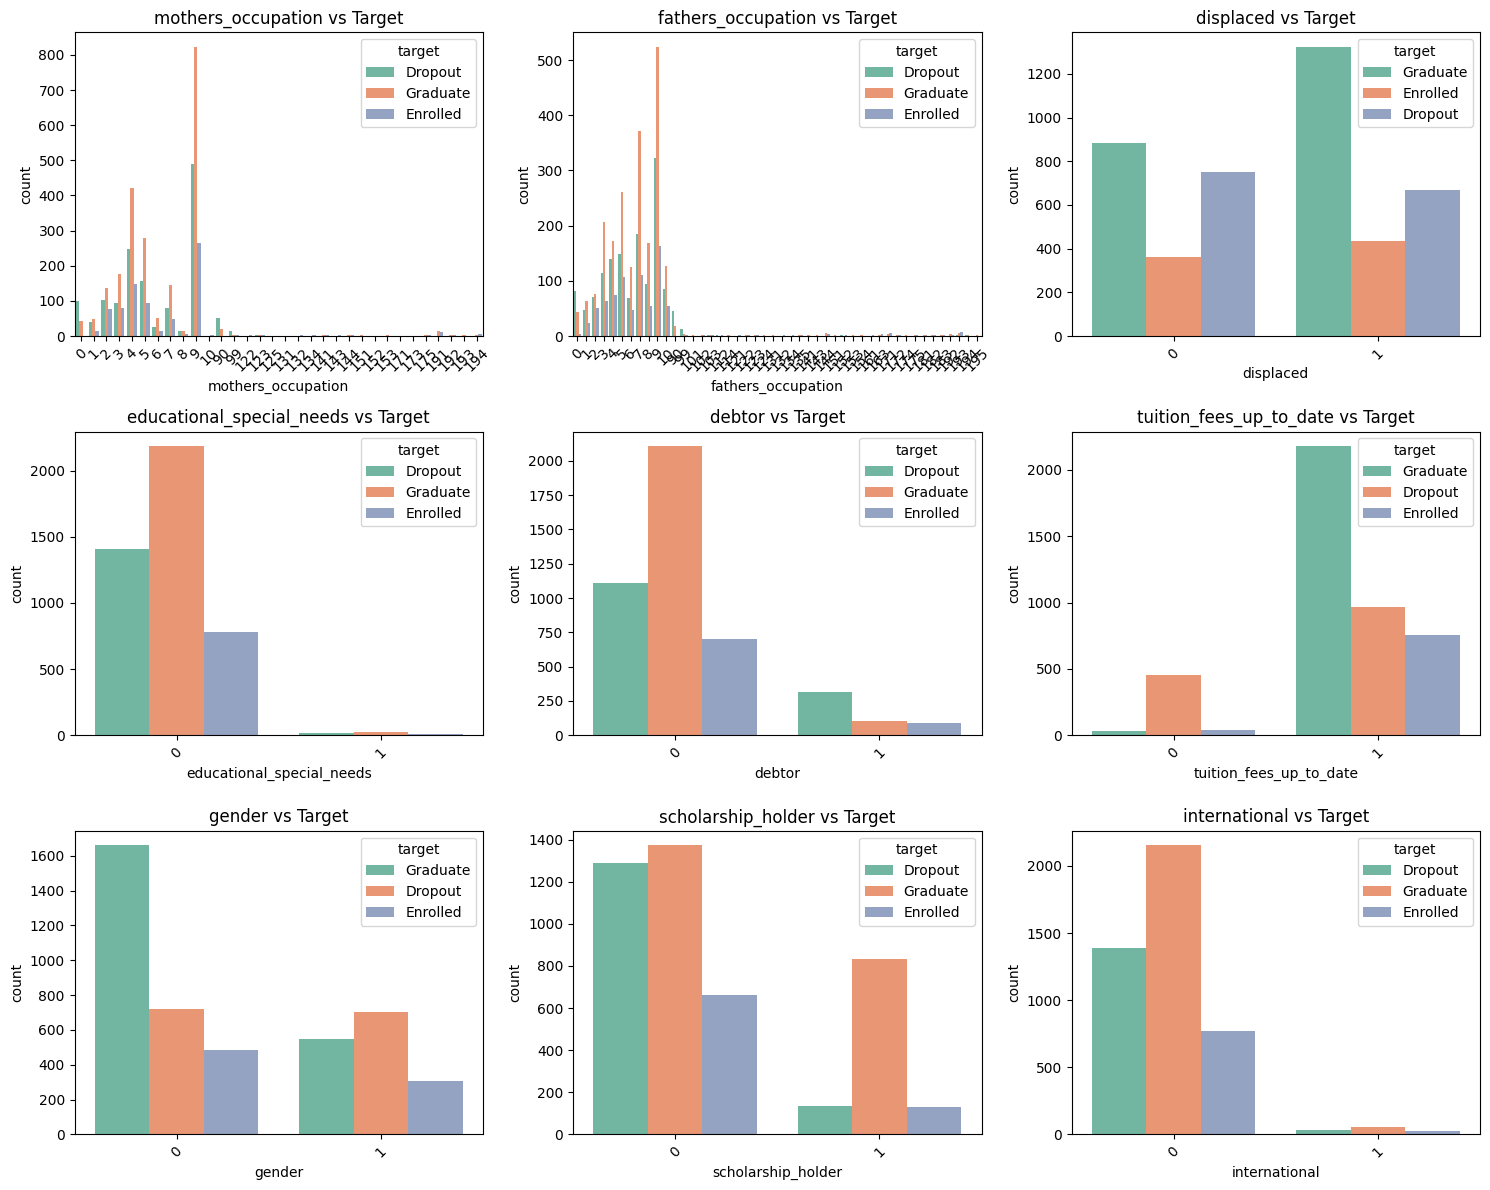

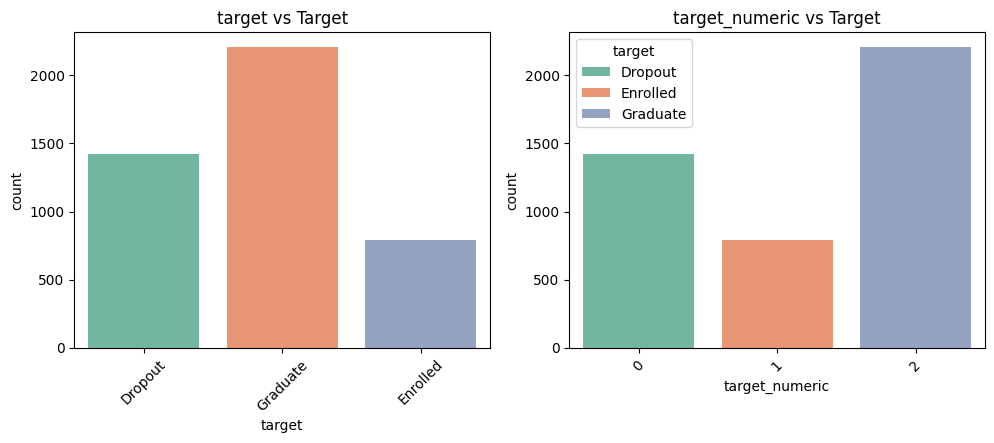

In [ ]:

# Define categorical variables
cat_cols = [col for col in student_data.columns if col not in num_cols]

# Define the number of columns per figure
cols_per_fig = 9  # Maximum 9 plots per figure
total_cols = len(cat_cols)
num_figs = (total_cols // cols_per_fig) + (total_cols % cols_per_fig > 0)  # Number of figures needed

# Loop through the features and create multiple figures
for fig_idx in range(num_figs):
    plt.figure(figsize=(15, 12))  # Create a new figure

    start_idx = fig_idx * cols_per_fig  # Starting index for this figure
    end_idx = min(start_idx + cols_per_fig, total_cols)  # Ending index

    # Create subplots for the current figure
    for i, col in enumerate(cat_cols[start_idx:end_idx], 1):
        plt.subplot(3, 3, i)  # Arrange in a 3x3 grid
        sns.countplot(x=col, hue="target", data=student_data, palette="Set2")
        plt.title(f"{col} vs Target")
        plt.xticks(rotation=45)  # Rotate x-axis labels for readability

    plt.tight_layout()
    plt.show()  # Show the current figure before moving to the next one


# Train Test Splitting
This keeps feature selection & missing value handling the same for all models.

In [ ]:

# Define Features & Target
X = student_data.drop(columns=["target","target_numeric"])  # Replace "target" with actual column name
y = student_data["target"]

# Train-Test Split (Stratified if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Copy datasets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()
X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()



# print data shape
print(f"XGBoost Dataset - Train: {X_train_xgb.shape}, Test: {X_test_xgb.shape}")
print(f"MLP Dataset - Train: {X_train_mlp.shape}, Test: {X_test_mlp.shape}")
print(f"Random Forest Dataset - Train: {X_train_rf.shape}, Test: {X_test_rf.shape}")


XGBoost Dataset - Train: (3539, 36), Test: (885, 36)
MLP Dataset - Train: (3539, 36), Test: (885, 36)
Random Forest Dataset - Train: (3539, 36), Test: (885, 36)


In [ ]:
X_train_mlp.head()

# Feature Engineering for MLP


---



## Skewness Removal
Outlier capping at first, then apply log transformation and box-cox to skewed columns after detecting skeness.

In [ ]:
# Check skewness in MLP dataset
skew_vals = X_train_mlp[num_cols].skew().sort_values(ascending=False)
print("📊 Skewness of Numerical Features:\n", skew_vals)

# Identify highly skewed columns (skewness > 1)
skewed_cols = skew_vals[skew_vals > 1].index.tolist()
print("🔍 Highly Skewed Columns:", skewed_cols)

# ===================== OUTLIER capping (For MLP Only) =====================
def cap_outliers(df, col_list, threshold=2.0):
    df_capped = df.copy()
    for col in col_list:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Cap values instead of removing
        df_capped[col] = np.clip(df_capped[col], lower_bound, upper_bound)

    return df_capped

# Apply capping instead of removing
X_train_mlp = cap_outliers(X_train_mlp, skewed_cols, threshold=2.0)
X_test_mlp = cap_outliers(X_test_mlp, skewed_cols, threshold=2.0)


print("✅ Outliers removed from highly skewed columns in MLP dataset.")

# Check final skewness after outlier removal
final_skew_vals = X_train_mlp[skewed_cols].skew().sort_values(ascending=False)
print("📊 Final Skewness After Outlier Removal:\n", final_skew_vals)

# Print final dataset sizes
print(f"XGBoost Dataset - Train: {X_train_xgb.shape}, Test: {X_test_xgb.shape}")
print(f"MLP Dataset (After Outlier Removal) - Train: {X_train_mlp.shape}, Test: {X_test_mlp.shape}")

📊 Skewness of Numerical Features:
 curricular_units_2nd_sem_without_evaluations    7.689504
curricular_units_1st_sem_without_evaluations    7.600303
curricular_units_2nd_sem_credited               4.677807
curricular_units_1st_sem_credited               4.202879
age_at_enrollment                               2.045877
curricular_units_1st_sem_enrolled               1.649653
curricular_units_1st_sem_evaluations            0.901003
curricular_units_2nd_sem_enrolled               0.852553
curricular_units_1st_sem_approved               0.775258
admission_grade                                 0.549938
curricular_units_2nd_sem_evaluations            0.348807
previous_qualification_grade                    0.328938
curricular_units_2nd_sem_approved               0.326537
inflation_rate                                  0.268841
unemployment_rate                               0.211110
gdp                                            -0.392630
curricular_units_2nd_sem_grade                 -1.300

##

In [ ]:


# First Log Transformation
skew_vals = X_train_mlp[num_cols].skew().sort_values(ascending=False)
skewed_cols = skew_vals[skew_vals > 1].index.tolist()

X_train_mlp[skewed_cols] = np.log1p(X_train_mlp[skewed_cols])
X_test_mlp[skewed_cols] = np.log1p(X_test_mlp[skewed_cols])

# Check skewness again
new_skew_vals = X_train_mlp[skewed_cols].skew().sort_values(ascending=False)
print(new_skew_vals)

# Apply sqrt transformation for still-skewed columns
highly_skewed_cols = new_skew_vals[new_skew_vals > 1].index.tolist()

for col in highly_skewed_cols:
    X_train_mlp[col], lambda_ = boxcox(X_train_mlp[col] + 1)  # Shift to avoid zero
    X_test_mlp[col] = boxcox(X_test_mlp[col] + 1, lambda_)

# Check final skewness after transformation
final_skew_vals = X_train_mlp[highly_skewed_cols].skew().sort_values(ascending=False)
print("📊 Final Skewness After Box-Cox Transformation:")
print(final_skew_vals)


age_at_enrollment    1.161563
dtype: float64
📊 Final Skewness After Box-Cox Transformation:
age_at_enrollment    0.0
dtype: float64


## High-Cardinality Categorical Feature Regrouping

In [ ]:
# List of high-cardinality categorical features
high_cardinality_cols = ['application_mode', 'course', 'nacionality',
                         'mothers_qualification', 'fathers_qualification',
                         'mothers_occupation', 'fathers_occupation']

# Check unique value counts
for col in high_cardinality_cols:
    print(f"{col}: {X_train_mlp[col].nunique()} unique values")


def group_rare_categories(df, col, threshold=20):
    """
    Groups rare categories into 'Other' if they appear less than a threshold.

    """
    value_counts = df[col].value_counts()
    rare_categories = value_counts[value_counts < threshold].index
    df[col] = df[col].replace(rare_categories, "Other")
    return df

# Apply rare category grouping to high-cardinality categorical features
for col in high_cardinality_cols:
    X_train_mlp = group_rare_categories(X_train_mlp, col, threshold=20)
    X_test_mlp = group_rare_categories(X_test_mlp, col, threshold=20)

print("✅ Rare categories grouped into 'Other'.")



application_mode: 18 unique values
course: 17 unique values
nacionality: 19 unique values
mothers_qualification: 28 unique values
fathers_qualification: 32 unique values
mothers_occupation: 31 unique values
fathers_occupation: 41 unique values
✅ Rare categories grouped into 'Other'.


## Encoding



### One hot key encoding(low-cardinality feature)


In [ ]:
low_cardinality_cols = ['marital_status', 'daytimeevening_attendance', 'previous_qualification',
                        'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date',
                        'gender', 'scholarship_holder', 'international']

# Apply One-Hot Encoding
X_train_mlp = pd.get_dummies(X_train_mlp, columns=low_cardinality_cols, drop_first=True)
X_test_mlp = pd.get_dummies(X_test_mlp, columns=low_cardinality_cols, drop_first=True)

print("✅ One-Hot Encoding applied to low-cardinality features.")


✅ One-Hot Encoding applied to low-cardinality features.


### Label Encoding(high-cardinality features)

In [ ]:
# Define high-cardinality categorical features
high_cardinality_cols = ['application_mode', 'course', 'nacionality',
                         'mothers_qualification', 'fathers_qualification',
                         'mothers_occupation', 'fathers_occupation']

# Apply Frequency Encoding
for col in high_cardinality_cols:
    # Compute category frequencies in training data
    freq_encoding = X_train_mlp[col].value_counts(normalize=True)

    # Map frequencies to train & test data
    X_train_mlp[col] = X_train_mlp[col].map(freq_encoding)
    X_test_mlp[col] = X_test_mlp[col].map(freq_encoding)

    # Fill NaN values in test set (for unseen categories)
    X_test_mlp[col].fillna(X_train_mlp[col].mean(), inplace=True)

print("✅ Frequency Encoding applied to high-cardinality features.")


✅ Frequency Encoding applied to high-cardinality features.


### Feature Alignment for Train Sets

In [ ]:
# Define numerical columns
num_cols = ["admission_grade", "unemployment_rate", "inflation_rate", "gdp", "age_at_enrollment", "previous_qualification_grade"] + \
           [col for col in student_data.columns if "curricular_units" in col]

# Ensure only existing numerical columns are used
num_cols = [col for col in num_cols if col in X_train_mlp.columns]

print("📊 Numerical features to be scaled:", num_cols)



common_cols = set(X_train_mlp.columns).intersection(set(X_test_mlp.columns))

X_train_mlp = X_train_mlp[list(common_cols)]
X_test_mlp = X_test_mlp[list(common_cols)]

print(f"✅ Aligned: X_train_mlp shape: {X_train_mlp.shape}, X_test_mlp shape: {X_test_mlp.shape}")



📊 Numerical features to be scaled: ['admission_grade', 'unemployment_rate', 'inflation_rate', 'gdp', 'age_at_enrollment', 'previous_qualification_grade', 'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_evaluations', 'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations', 'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled', 'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade', 'curricular_units_2nd_sem_without_evaluations']
✅ Aligned: X_train_mlp shape: (3539, 50), X_test_mlp shape: (885, 50)


### Target Variable Encoding

In [ ]:

if y_train_mlp.dtype == 'object':
    le = LabelEncoder()
    y_train_mlp = pd.Series(le.fit_transform(y_train_mlp), name="target")
    y_test_mlp = pd.Series(le.transform(y_test_mlp), name="target")
    print("✅ Converted y_train_mlp to integer labels.")


✅ Converted y_train_mlp to integer labels.


In [ ]:
X_train_mlp.head()

,fathers_occupation,curricular_units_2nd_sem_without_evaluations,daytimeevening_attendance_1,course,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_evaluations,marital_status_6,gender_1,debtor_1,admission_grade,...,unemployment_rate,previous_qualification_3,previous_qualification_19,scholarship_holder_1,mothers_qualification,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_approved,inflation_rate,tuition_fees_up_to_date_1,marital_status_4
2283,0.047188,0,True,0.082227,0,13,False,True,False,118.6,...,13.9,False,False,False,0.018932,0,10,-0.3,True,False
3874,0.031930,0,True,0.032495,0,5,False,True,True,120.0,...,12.7,False,False,False,0.243854,0,0,3.7,False,False
2281,0.055948,0,True,0.048319,0,15,False,True,False,140.0,...,15.5,False,False,False,0.243854,0,4,2.8,True,False
817,0.087595,0,True,0.049166,0,6,False,False,False,120.8,...,12.4,False,False,False,0.243854,0,6,0.5,True,False
404,0.115852,0,True,0.171517,0,8,False,False,False,131.3,...,10.8,False,False,False,0.224075,0,7,1.4,True,False


# Model Training: MLP

---



## Base line model

#### Model Architecture
- **Input Layer**: Features from `X_train_mlp`
- **Hidden Layers**:
  - 128 neurons (ReLU, L2 regularization, 50% Dropout)
  - 64 neurons (ReLU, L2 regularization, 50% Dropout)
  - 32 neurons (ReLU, L2 regularization, 50% Dropout)
- **Output Layer**: `num_classes` neurons (Softmax activation)

#### Regularization
- L2 Regularization (`λ = 0.001`)
- Dropout (50%)

#### Training Details
- **Optimizer**: Adam (learning rate = 0.0005)
- **Loss Function**: Sparse Categorical Crossentropy
- **Class Balancing**: Class weights computed using `compute_class_weight('balanced', ...)`
- **Hyperparameters**:
  - Epochs: 50
  - Batch Size: 32
- **Validation Set**: `(X_test_mlp, y_test_mlp)`


In [ ]:

# Define the number of classes (assuming y_train_mlp is already integer-encoded)
num_classes = len(y_train_mlp.unique())

# Build the MLP model with regularization (Dropout and L2)
mlp_model = keras.models.Sequential([
    # First hidden layer with L2 regularization and Dropout
    keras.layers.Dense(128, activation="relu", input_shape=(X_train_mlp.shape[1],),
                       kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),  # 50% dropout

    # Second hidden layer
    keras.layers.Dense(64, activation="relu",
                       kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

    # Third hidden layer
    keras.layers.Dense(32, activation="relu",
                       kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dropout(0.5),

    # Output layer
    keras.layers.Dense(num_classes, activation="softmax")
])

# Compile the model with the same loss and optimizer settings as before
optimizer = keras.optimizers.Adam(learning_rate=0.0005028429574448033)
mlp_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Display the model architecture
mlp_model.summary()

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_mlp), y=y_train_mlp)
class_weight_dict = dict(enumerate(class_weights))

print("Computed Class Weights:", class_weight_dict)

# Train MLP with class weights
history = mlp_model.fit(
    X_train_mlp, y_train_mlp,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_mlp, y_test_mlp),
    class_weight=class_weight_dict,  # Apply class weights
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 128)                 │           6,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,963 (66.26 KB)

 Trainable params: 16,963 (66.26 KB)

 Non-trainable params: 0 (0.00 B)

Computed Class Weights: {0: 1.0375256523013778, 1: 1.857742782152231, 2: 0.6676098849273722}
Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3623 - loss: 16.5434 - val_accuracy: 0.1819 - val_loss: 1.3083
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3213 - loss: 4.5762 - val_accuracy: 0.1808 - val_loss: 1.2633
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3444 - loss: 2.4940 - val_accuracy: 0.2633 - val_loss: 1.2566
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3325 - loss: 1.8811 - val_accuracy: 0.2927 - val_loss: 1.2408
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3106 - loss: 1.6369 - val_accuracy: 0.1797 - val_loss: 1.2356
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3389 - loss: 1.4476 - val_accuracy: 0.2757 - val_loss: 1.2318
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3218 - loss: 1.3770 - val_accuracy: 0.1797 - val_loss: 1.2300
Epoch 8/50

### Baseline Model Evaluation

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7646 - loss: 0.5881 
🎯 MLP Model Test Accuracy: 0.7616


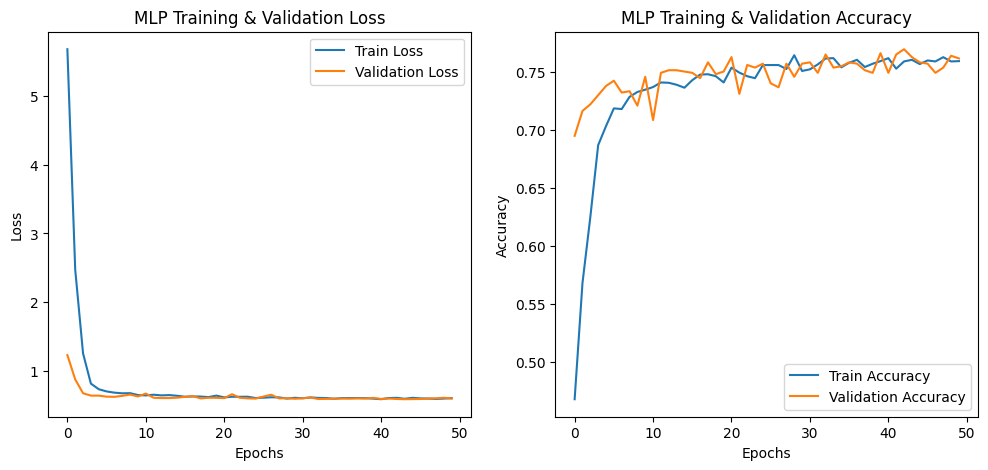

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


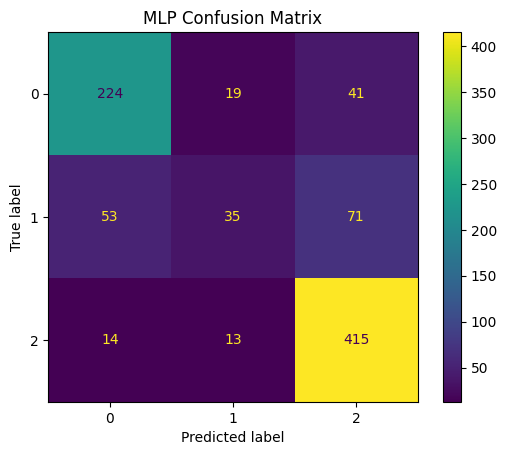

📊 MLP Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       284
           1       0.52      0.22      0.31       159
           2       0.79      0.94      0.86       442

    accuracy                           0.76       885
   macro avg       0.69      0.65      0.65       885
weighted avg       0.73      0.76      0.73       885



In [ ]:
# Evaluate model on test data
test_loss, test_acc = mlp_model.evaluate(X_test_mlp, y_test_mlp)

print(f"🎯 MLP Model Test Accuracy: {test_acc:.4f}")


# Plot training history
plt.figure(figsize=(12,5))

# Loss Curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("MLP Training & Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy Curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("MLP Training & Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


# Predict using MLP
y_pred_mlp = np.argmax(mlp_model.predict(X_test_mlp), axis=1)

# Confusion Matrix
cm_mlp = confusion_matrix(y_test_mlp, y_pred_mlp)
ConfusionMatrixDisplay(cm_mlp).plot()
plt.title("MLP Confusion Matrix")
plt.show()


from sklearn.metrics import classification_report

# Generate classification report
report_mlp = classification_report(y_test_mlp, y_pred_mlp, digits=2)

# Print classification report
print("📊 MLP Classification Report:\n")
print(report_mlp)

# Use Bayesian Optimization

In [ ]:

# Define the objective function for Optuna
def objective(trial):
    hidden_layers = trial.suggest_int("hidden_layers", 1, 4)
    neurons = trial.suggest_categorical("neurons", [64, 128, 256])
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    # search for L2 regularization parameter
    l2_rate = trial.suggest_loguniform("l2_rate", 1e-6, 1e-2)

    model = keras.models.Sequential()
    # First Dense layer with L2 regularization
    model.add(keras.layers.Dense(neurons, activation="relu",
                                 input_shape=(X_train_mlp.shape[1],),
                                 kernel_regularizer=keras.regularizers.l2(l2_rate)))

    # Additional hidden layers with L2 regularization and dropout
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(neurons // 2, activation="relu",
                                     kernel_regularizer=keras.regularizers.l2(l2_rate)))
        model.add(keras.layers.Dropout(dropout_rate))

    # Output layer
    model.add(keras.layers.Dense(len(np.unique(y_train_mlp)), activation="softmax"))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    history = model.fit(X_train_mlp, y_train_mlp, epochs=50, batch_size=64, verbose=0)
    return history.history["accuracy"][-1]  # Return the final accuracy

# Run Bayesian Optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)  # 50 trials

# Print the best hyperparameters and best accuracy
print("✅ Best Hyperparameters Found:", study.best_trial.params)
print("🎯 Best Accuracy Achieved:", study.best_trial.value)



[I 2025-03-13 14:40:06,269] A new study created in memory with name: no-name-b08b46af-9f51-48f4-9117-8c4ba38afbe4
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-03-13 14:40:22,149] Trial 0 finished with value: 0.7485165596008301 and parameters: {'hidden_layers': 2, 'neurons': 256, 'dropout_rate': 0.4011932824400447, 'learning_rate': 0.0005494285911617433, 'l2_rate': 2.01312029309089e-05}. Best is trial 0 with value: 0.7485165596008301.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super()

✅ Best Hyperparameters Found: {'hidden_layers': 1, 'neurons': 256, 'dropout_rate': 0.4522757661993285, 'learning_rate': 0.00024431553614437997, 'l2_rate': 1.1551212895511089e-06}
🎯 Best Accuracy Achieved: 0.7753602862358093


### Optimized MLP Model (Optuna Tuned)

#### Model Architecture
- **Input Layer**: Features from `X_train_mlp`
- **Hidden Layers**:
  - 256 neurons (ReLU, L2 regularization = 2.32e-06, Dropout = 30.88%)
- **Output Layer**: `num_classes` neurons (Softmax activation)

#### Regularization
- L2 Regularization (`λ = 2.32e-06`)
- Dropout (`30.88%`)

#### Training Details
- **Optimizer**: Adam (learning rate = 0.00094)
- **Loss Function**: Sparse Categorical Crossentropy
- **Hyperparameters**:
  - Epochs: 50
  - Batch Size: 32
- **Validation Set**: `(X_test_mlp, y_test_mlp)`

#### Evaluation
- **Test Accuracy**: Displayed after model evaluation
- **Metrics**:
  - **Training History**: Loss and accuracy curves
  - **Confusion Matrix**: To visualize class-wise performance
  - **Classification Report**: Precision, recall, and F1-score analysis


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_105 (Dense)                    │ (None, 256)                 │          13,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_39 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_106 (Dense)                    │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,827 (54.01 KB)

 Trainable params: 13,827 (54.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4395 - loss: 7.0224 - val_accuracy: 0.6949 - val_loss: 1.2284
Epoch 2/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5360 - loss: 2.9967 - val_accuracy: 0.7164 - val_loss: 0.8745
Epoch 3/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6112 - loss: 1.4492 - val_accuracy: 0.7220 - val_loss: 0.6730
Epoch 4/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6739 - loss: 0.8782 - val_accuracy: 0.7299 - val_loss: 0.6380
Epoch 5/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7042 - loss: 0.7518 - val_accuracy: 0.7379 - val_loss: 0.6384
Epoch 6/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7222 - loss: 0.6853 - val_accuracy: 0.7424 - val_loss: 0.6230
Epoch 7/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7133 - loss: 0.6859 - val_accuracy: 0.7322 - val_loss: 0.6206
Epoch 8/50
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7117 - loss: 0.6897 - val_accuracy: 0

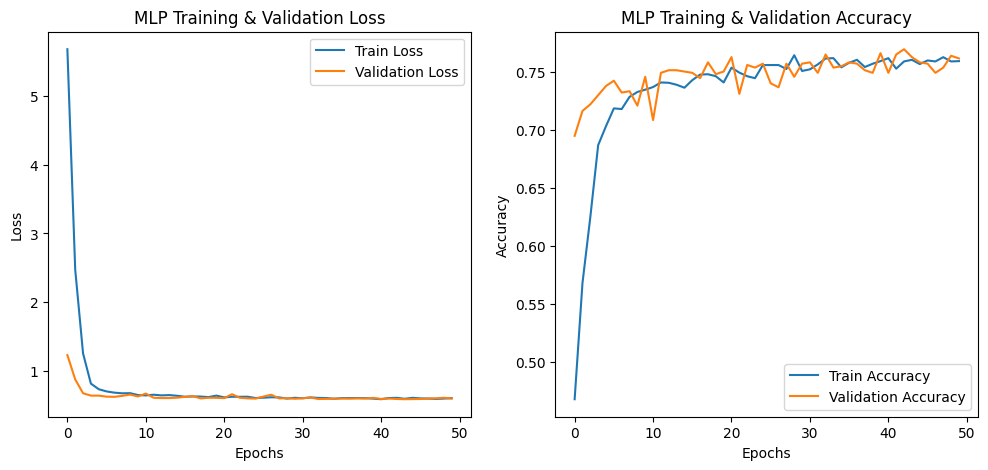

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


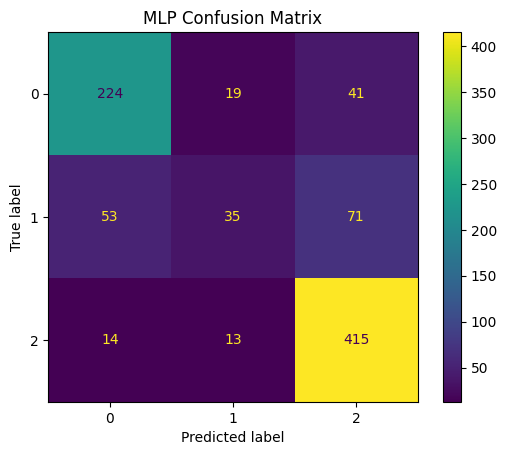

              precision    recall  f1-score   support

           0       0.77      0.79      0.78       284
           1       0.52      0.22      0.31       159
           2       0.79      0.94      0.86       442

    accuracy                           0.76       885
   macro avg       0.69      0.65      0.65       885
weighted avg       0.73      0.76      0.73       885



In [ ]:

# Set the best hyperparameters found by Optuna
hidden_layers = 1
neurons = 256
dropout_rate = 0.3087527671261363
learning_rate = 0.0009389338998318705
l2_rate = 2.320266812148098e-06

num_classes = len(y_train_mlp.unique())

# Build the MLP model with L2 regularization and dropout
mlp_model = keras.models.Sequential()
# First (and only) hidden layer with L2 regularization
mlp_model.add(keras.layers.Dense(
    neurons,
    activation="relu",
    input_shape=(X_train_mlp.shape[1],),
    kernel_regularizer=keras.regularizers.l2(l2_rate)
))
# Dropout layer after the first hidden layer
mlp_model.add(keras.layers.Dropout(dropout_rate))


# Output layer with softmax activation for multi-class classification
mlp_model.add(keras.layers.Dense(num_classes, activation="softmax"))

# Compile the model with the specified learning rate and loss function
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
mlp_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# Display the model architecture
mlp_model.summary()

# Train the model with the training set and validate on the test set
history = mlp_model.fit(
    X_train_mlp, y_train_mlp,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_mlp, y_test_mlp),
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_acc = mlp_model.evaluate(X_test_mlp, y_test_mlp, verbose=0)
print(f"🎯 MLP Model Test Accuracy: {test_acc:.4f}")

# Plot the training history curves
plt.figure(figsize=(12,5))

# Plot Loss Curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MLP Training & Validation Loss")
plt.legend()

# Plot Accuracy Curve
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("MLP Training & Validation Accuracy")
plt.legend()

plt.show()

# Predict on the test set and display the confusion matrix
y_pred = np.argmax(mlp_model.predict(X_test_mlp), axis=1)
cm = confusion_matrix(y_test_mlp, y_pred)
ConfusionMatrixDisplay(cm).plot()
plt.title("MLP Confusion Matrix")
plt.show()

# Print classification report for further evaluation
print(classification_report(y_test_mlp, y_pred))


# Feature Engineering for XGBoost

---



In [ ]:
# =============================================================================
# 1. Define Numerical and Categorical Columns
# =============================================================================
num_cols = ["admission_grade", "unemployment_rate", "inflation_rate", "gdp",
            "age_at_enrollment", "previous_qualification_grade"] + \
           [col for col in X_train_xgb.columns if "curricular_units" in col]

# Identify categorical columns (assuming object types)
categorical_cols = list(X_train_xgb.select_dtypes(include=['object']).columns)
print("Categorical columns:", categorical_cols)


Categorical columns: []


## Feature Selection using XGBoost

In [ ]:

# =============================================================================
# 2. Box-Cox Transformation for Numerical Features
# =============================================================================

# Custom transformer for Box-Cox transformation
class BoxCoxTransformer:
    def __init__(self, threshold=1.0):
        self.threshold = threshold  # transform only if |skewness| > threshold
        self.params = {}  # to store (shift, lambda) for each column

    def fit(self, X, columns):
        self.columns = columns
        for col in columns:
            current_skew = skew(X[col])
            if np.abs(current_skew) > self.threshold:
                # Shift if there are non-positive values
                shift = abs(X[col].min()) + 1 if X[col].min() <= 0 else 0
                # Calculate Box-Cox lambda (we ignore the transformed values here)
                _, fitted_lambda = boxcox(X[col] + shift)
                self.params[col] = (shift, fitted_lambda)
                print(f"✅ Fitted Box-Cox on '{col}' with shift={shift}, lambda={fitted_lambda:.2f} (skewness: {current_skew:.2f})")
            else:
                self.params[col] = None
                print(f"✅ '{col}' skewness ({current_skew:.2f}) is within threshold; no transformation applied.")
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns:
            if self.params[col] is not None:
                shift, fitted_lambda = self.params[col]
                X_transformed[col] = boxcox(X_transformed[col] + shift, lmbda=fitted_lambda)
        return X_transformed

# Instantiate and fit the transformer on the training set
boxcox_transformer = BoxCoxTransformer(threshold=1.0)
boxcox_transformer.fit(X_train_xgb, num_cols)

# Transform both training and test sets
X_train_transformed = boxcox_transformer.transform(X_train_xgb)
X_test_transformed = boxcox_transformer.transform(X_test_xgb)

print("✅ Box-Cox transformation applied to numerical features.")



✅ 'admission_grade' skewness (0.55) is within threshold; no transformation applied.
✅ 'unemployment_rate' skewness (0.21) is within threshold; no transformation applied.
✅ 'inflation_rate' skewness (0.27) is within threshold; no transformation applied.
✅ 'gdp' skewness (-0.39) is within threshold; no transformation applied.
✅ Fitted Box-Cox on 'age_at_enrollment' with shift=0, lambda=-3.44 (skewness: 2.05)
✅ 'previous_qualification_grade' skewness (0.33) is within threshold; no transformation applied.
✅ Fitted Box-Cox on 'curricular_units_1st_sem_credited' with shift=1, lambda=-4.43 (skewness: 4.20)
✅ Fitted Box-Cox on 'curricular_units_1st_sem_enrolled' with shift=1, lambda=0.75 (skewness: 1.65)
✅ 'curricular_units_1st_sem_evaluations' skewness (0.90) is within threshold; no transformation applied.
✅ 'curricular_units_1st_sem_approved' skewness (0.77) is within threshold; no transformation applied.
✅ Fitted Box-Cox on 'curricular_units_1st_sem_grade' with shift=1.0, lambda=1.79 (skewn

## Encoding

In [ ]:
# =============================================================================
# 3. Categorical Encoding (One-Hot Encoding)
# =============================================================================
# Apply one-hot encoding on categorical features using pd.get_dummies.
# Note: We align the test set with the training set to ensure consistent features.
if categorical_cols:
    X_train_encoded = pd.get_dummies(X_train_transformed, columns=categorical_cols, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test_transformed, columns=categorical_cols, drop_first=True)
    # Align test set columns with training set columns
    X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)
else:
    X_train_encoded = X_train_transformed.copy()
    X_test_encoded = X_test_transformed.copy()

print("✅ Categorical encoding applied.")
print("X_train shape after encoding:", X_train_encoded.shape)
print("X_test shape after encoding:", X_test_encoded.shape)





✅ Categorical encoding applied.
X_train shape after encoding: (3539, 36)
X_test shape after encoding: (885, 36)


# Model Training: XGBoost

---



## Baseline XGBoost Model

#### Model Setup
- **Algorithm**: XGBoost Classifier (`XGBClassifier`)
- **Target Encoding**: Label encoding applied to `y_train_xgb` and `y_test_xgb`
- **Hyperparameters**:
  - Default settings
  - `use_label_encoder=False`
  - `eval_metric='logloss'`
  - `random_state=42`

#### Training & Evaluation
- **Training Data**: `X_train_encoded`, `y_train_xgb`
- **Test Data**: `X_test_encoded`, `y_test_xgb`

#### Performance Metrics
- **Accuracy**: Displayed after model evaluation
- **F1 Score**: Weighted F1 score
- **ROC-AUC**: Multi-class One-vs-Rest (OvR) approach
- **Classification Report**: Precision, recall, and F1-score for each class


In [ ]:
# =============================================================================
# 4. Baseline XGBoost Model Training and Evaluation
# =============================================================================

# Encode the target variable for XGBoost dataset
label_encoder = LabelEncoder()
y_train_xgb = label_encoder.fit_transform(y_train_xgb)
y_test_xgb = label_encoder.transform(y_test_xgb)



# Train a baseline XGBoost model using default parameters
baseline_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
baseline_model.fit(X_train_encoded, y_train_xgb)
y_pred_baseline = baseline_model.predict(X_test_encoded)

# Evaluate baseline model
acc_baseline = accuracy_score(y_test_xgb, y_pred_baseline)
f1_baseline = f1_score(y_test_xgb, y_pred_baseline, average='weighted')
roc_auc_baseline = roc_auc_score(y_test_xgb, baseline_model.predict_proba(X_test_encoded), multi_class='ovr')

print("✅ Baseline Model Performance:")
print("Accuracy:", acc_baseline)
print("F1 Score:", f1_baseline)
print("ROC-AUC:", roc_auc_baseline)
print("Classification Report:\n", classification_report(y_test_xgb, y_pred_baseline))



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:46:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Baseline Model Performance:
Accuracy: 0.768361581920904
F1 Score: 0.7623715861563073
ROC-AUC: 0.8893107512023573
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.76      0.78       284
           1       0.53      0.45      0.49       159
           2       0.82      0.89      0.85       442

    accuracy                           0.77       885
   macro avg       0.72      0.70      0.71       885
weighted avg       0.76      0.77      0.76       885



### XGBoost Hyperparameter Tuning with GridSearchCV

#### Grid Search Setup
- **Hyperparameter Grid**:
  - `max_depth`: [3, 5, 7]
  - `learning_rate`: [0.01, 0.1, 0.2]
  - `n_estimators`: [100, 200, 300]
  - `subsample`: [0.8, 1.0]
  - `colsample_bytree`: [0.8, 1.0]
- **Estimator**: `XGBClassifier` with `use_label_encoder=False` and `eval_metric='logloss'`
- **Cross-Validation**: 3-fold CV (`cv=3`)
- **Scoring Metric**: Accuracy
- **Parallel Processing**: `n_jobs=-1` (utilizing all available CPU cores)

#### Best Model Selection
- **Best Parameters**: Extracted from `grid_search.best_params_`
- **Best Cross-Validation Score**: Reported from `grid_search.best_score_`

#### Performance Evaluation on Test Data
- **Test Accuracy**: Computed using `accuracy_score`
- **F1 Score**: Weighted F1-score
- **ROC-AUC Score**: Multi-class One-vs-Rest (OvR) approach
- **Classification Report**: Precision, recall, and F1-score analysis


In [ ]:
# =============================================================================
# 5. Hyperparameter Tuning with GridSearchCV
# =============================================================================

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_encoded, y_train_xgb)
print("✅ Best parameters found:", grid_search.best_params_)
print("✅ Best cross-validation score:", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_encoded)
acc_best = accuracy_score(y_test_xgb, y_pred_best)
f1_best = f1_score(y_test_xgb, y_pred_best, average='weighted')
roc_auc_best = roc_auc_score(y_test_xgb, best_model.predict_proba(X_test_encoded), multi_class='ovr')

print("✅ Tuned Model Performance:")
print("Accuracy:", acc_best)
print("F1 Score:", f1_best)
print("ROC-AUC:", roc_auc_best)
print("Classification Report:\n", classification_report(y_test_xgb, y_pred_best))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
✅ Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
✅ Best cross-validation score: 0.7767745815423392
✅ Tuned Model Performance:
Accuracy: 0.7627118644067796
F1 Score: 0.7519477527006111
ROC-AUC: 0.8908921209741267
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.74      0.77       284
           1       0.52      0.38      0.44       159
           2       0.80      0.91      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.68      0.69       885
weighted avg       0.75      0.76      0.75       885



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:51:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


## Best Model Training Visualization

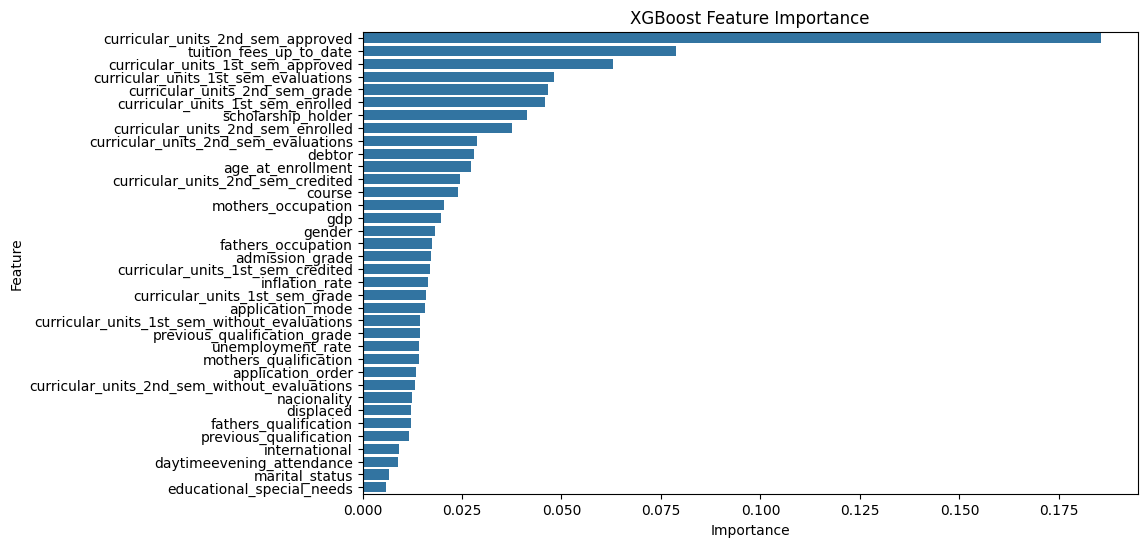

In [ ]:

# =============================================================================
# 6. Feature Importance Plotting
# =============================================================================

feature_importance = best_model.feature_importances_
features = X_train_encoded.columns
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importance}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


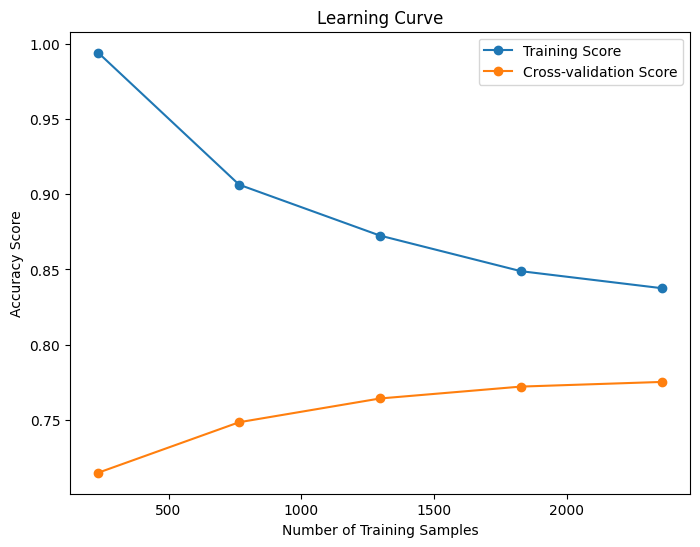

In [ ]:

# =============================================================================
# 7. Learning Curve Plotting
# =============================================================================

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_encoded, y_train_xgb, cv=3, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training Score")
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation Score")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Feature Engineering for Random Forest

---



## Encoding

In [ ]:

# Identify numerical and categorical columns
num_features = X_train_rf.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_train_rf.select_dtypes(include=['object']).columns

# Create pipelines for numerical and categorical processing
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))  # Fill missing values
])

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # Fill missing categorical values
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # One-hot encoding
])

# Combine pipelines
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),
    ("cat", cat_pipeline, cat_features)
])

# Apply transformation
X_train_rf_transformed = preprocessor.fit_transform(X_train_rf)
X_test_rf_transformed = preprocessor.transform(X_test_rf)

# Print shape of transformed datasets
print(f"Transformed X_train shape: {X_train_rf_transformed.shape}")
print(f"Transformed X_test shape: {X_test_rf_transformed.shape}")



Transformed X_train shape: (3539, 36)
Transformed X_test shape: (885, 36)


# Training Random Forest

---



In [ ]:
# Train a baseline Random Forest model
rf_baseline = RandomForestClassifier(random_state=42)
rf_baseline.fit(X_train_rf_transformed, y_train_rf)

# Evaluate baseline performance
y_pred = rf_baseline.predict(X_test_rf_transformed)
baseline_accuracy = accuracy_score(y_test_rf, y_pred)
print(f"Baseline Random Forest Accuracy: {baseline_accuracy:.4f}")

# Generate classification report
report = classification_report(y_test_rf, y_pred)
print(report)


Baseline Random Forest Accuracy: 0.7672
              precision    recall  f1-score   support

     Dropout       0.81      0.75      0.78       284
    Enrolled       0.57      0.37      0.45       159
    Graduate       0.78      0.92      0.85       442

    accuracy                           0.77       885
   macro avg       0.72      0.68      0.69       885
weighted avg       0.75      0.77      0.75       885



## Hyperparameter Tuning & Training
### Model Performance Comparison

#### Evaluation Metrics
- **Accuracy**: Measures overall classification correctness.
- **F1 Score**: Weighted F1-score to account for class imbalance.
- **ROC-AUC**: Multi-class One-vs-Rest (OvR) area under the curve.
- **Inference Time (s)**: Time taken for model prediction on test data.

#### Models Evaluated
1. **Random Forest**
   - Best estimator from hyperparameter tuning (`rf_tuned.best_estimator_`).
   - Performance evaluated on `X_test_rf_transformed`, `y_test_rf`.
  
2. **XGBoost**
   - Best tuned model from GridSearchCV (`best_model`).
   - Predictions made on `X_test_encoded`, evaluated against `y_test_xgb`.

3. **MLP (Neural Network)**
   - Predictions obtained using `mlp_model.predict(X_test_mlp)`.
   - Metrics computed from test accuracy, F1-score, and ROC-AUC.

#### Results Visualization
- Results stored in a structured dictionary and converted into a pandas DataFrame.
- `display(results_df)` used to present model comparisons effectively.


In [ ]:

# Define parameter grid
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False]
}

# Randomized search
rf_tuned = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=10,  # Number of combinations to try
    cv=5,
    scoring="accuracy",
    random_state=42,
    n_jobs=-1
)

# Fit the model
rf_tuned.fit(X_train_rf_transformed, y_train_rf)

# Best parameters
print(f"Best Parameters: {rf_tuned.best_params_}")

# Evaluate tuned model
y_pred_tuned = rf_tuned.best_estimator_.predict(X_test_rf_transformed)
tuned_accuracy = accuracy_score(y_test_rf, y_pred_tuned)
print(f"Tuned Random Forest Accuracy: {tuned_accuracy:.4f}")


# Model Comparison

---


#### Evaluation Metrics
- **Accuracy**: Measures overall classification correctness.
- **F1 Score**: Weighted F1-score to account for class imbalance.
- **ROC-AUC**: Multi-class One-vs-Rest (OvR) area under the curve.
- **Inference Time (s)**: Time taken for model prediction on test data.

#### Models Evaluated
1. **Random Forest**
   - Best estimator from hyperparameter tuning (`rf_tuned.best_estimator_`).
   - Performance evaluated on `X_test_rf_transformed`, `y_test_rf`.
  
2. **XGBoost**
   - Best tuned model from GridSearchCV (`best_model`).
   - Predictions made on `X_test_encoded`, evaluated against `y_test_xgb`.

3. **MLP (Neural Network)**
   - Predictions obtained using `mlp_model.predict(X_test_mlp)`.
   - Metrics computed from test accuracy, F1-score, and ROC-AUC.

#### Results Visualization
- Results stored in a structured dictionary and converted into a pandas DataFrame.
- `display(results_df)` used to present model comparisons effectively.


In [ ]:
import time
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Initialize a dictionary to store the results
results = {}

# 1. Evaluate Random Forest Model
time_start = time.time()
y_pred_rf = rf_tuned.best_estimator_.predict(X_test_rf_transformed)
time_end = time.time()
rf_inference_time = time_end - time_start

results['Random Forest'] = {
    'Accuracy': accuracy_score(y_test_rf, y_pred_rf),
    'F1 Score': f1_score(y_test_rf, y_pred_rf, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test_rf, rf_tuned.best_estimator_.predict_proba(X_test_rf_transformed), multi_class='ovr'),
    'Inference Time (s)': rf_inference_time
}

# 2. Evaluate XGBoost Model
time_start = time.time()
y_pred_xgb = best_model.predict(X_test_encoded)
time_end = time.time()
xgb_inference_time = time_end - time_start

results['XGBoost'] = {
    'Accuracy': accuracy_score(y_test_xgb, y_pred_xgb),
    'F1 Score': f1_score(y_test_xgb, y_pred_xgb, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test_xgb, best_model.predict_proba(X_test_encoded), multi_class='ovr'),
    'Inference Time (s)': xgb_inference_time
}

# 3. Evaluate MLP Model
time_start = time.time()
y_pred_mlp = np.argmax(mlp_model.predict(X_test_mlp), axis=1)
time_end = time.time()
mlp_inference_time = time_end - time_start

test_loss, test_acc = mlp_model.evaluate(X_test_mlp, y_test_mlp, verbose=0)

results['MLP'] = {
    'Accuracy': test_acc,
    'F1 Score': f1_score(y_test_mlp, y_pred_mlp, average='weighted'),
    'ROC-AUC': roc_auc_score(y_test_mlp, mlp_model.predict(X_test_mlp), multi_class='ovr'),
    'Inference Time (s)': mlp_inference_time
}

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results).T

# Display the results
from IPython.display import display

print("Model Performance Comparison:")
display(results_df)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model Performance Comparison:


,Accuracy,F1 Score,ROC-AUC,Inference Time (s)
Random Forest,0.766102,0.753598,0.883288,0.010366
XGBoost,0.762712,0.751948,0.890892,0.010496
MLP,0.761582,0.733466,0.874560,0.191453
